# DATA 266 - Homework 4: Complete RLHF Pipeline
## Reward Modeling, PPO Fine-Tuning, LoRA Comparison + DCGAN Bonus

**Student Name:** [Your Name]  
**Student ID:** [Your ID]  
**Date:** December 2025

---

## Assignment Overview

This notebook implements a complete **Reinforcement Learning from Human Feedback (RLHF)** training pipeline:

1. **Part 1:** Train a Reward Model from human preference data
2. **Part 2:** Fine-Tune Policy Models using PPO (Full + LoRA)
3. **Part 3:** Comprehensive Evaluation & Reporting
4. **BONUS:** DCGAN for Medical Image Synthesis (3 bonus points)

**Total Possible Score:** 23/20 points


## Setup and Installation


In [2]:
# Install required packages
!pip install -q transformers datasets accelerate peft trl torch torchvision
!pip install -q medmnist matplotlib seaborn pandas numpy tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.1 MB/s eta 0:00:00


### Import Libraries and Configure Environment


In [3]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    AutoTokenizer, AutoModelForCausalLM, set_seed
)
from peft import LoraConfig, get_peft_model, TaskType, PeftModel
from trl import AutoModelForCausalLMWithValueHead

from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import os, random, warnings, gc
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Configuration
SEED = 42
set_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"📊 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("⚠️  Running on CPU - training will be slower")


🖥️  Using device: cuda
📊 GPU: NVIDIA A100-SXM4-80GB
💾 Memory: 85.17 GB


## Part 1: Reward Model Training

### 1.1 Load Stanford Human Preferences Dataset


In [4]:
# Load Stanford Human Preferences Dataset
print("📥 Loading Stanford Human Preferences Dataset...")
shp_dataset = load_dataset("stanfordnlp/SHP")

print("\n📋 Dataset structure:")
print(shp_dataset)
print("\n🔍 Sample from train split:")
print(shp_dataset['train'][0])


📥 Loading Stanford Human Preferences Dataset...


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

askacademia/train.json:   0%|          | 0.00/69.4M [00:00<?, ?B/s]

train.json: 0.00B [00:00, ?B/s]

askbaking/train.json:   0%|          | 0.00/60.7M [00:00<?, ?B/s]

train.json: 0.00B [00:00, ?B/s]

askculinary/train.json:   0%|          | 0.00/71.3M [00:00<?, ?B/s]

askdocs/train.json:   0%|          | 0.00/21.2M [00:00<?, ?B/s]

askengineers/train.json:   0%|          | 0.00/102M [00:00<?, ?B/s]

askhistorians/train.json:   0%|          | 0.00/16.5M [00:00<?, ?B/s]

askhr/train.json:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

askphilosophy/train.json:   0%|          | 0.00/24.0M [00:00<?, ?B/s]

askphysics/train.json:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

askscience/train.json:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

asksciencefiction/train.json:   0%|          | 0.00/44.0M [00:00<?, ?B/s]

train.json: 0.00B [00:00, ?B/s]

train.json: 0.00B [00:00, ?B/s]

changemyview/train.json:   0%|          | 0.00/149M [00:00<?, ?B/s]

explainlikeimfive/train.json:   0%|          | 0.00/38.2M [00:00<?, ?B/s]

legaladvice/train.json:   0%|          | 0.00/61.0M [00:00<?, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/348718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/18436 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/18409 [00:00<?, ? examples/s]


📋 Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['post_id', 'domain', 'upvote_ratio', 'history', 'c_root_id_A', 'c_root_id_B', 'created_at_utc_A', 'created_at_utc_B', 'score_A', 'score_B', 'human_ref_A', 'human_ref_B', 'labels', 'seconds_difference', 'score_ratio'],
        num_rows: 348718
    })
    validation: Dataset({
        features: ['post_id', 'domain', 'upvote_ratio', 'history', 'c_root_id_A', 'c_root_id_B', 'created_at_utc_A', 'created_at_utc_B', 'score_A', 'score_B', 'human_ref_A', 'human_ref_B', 'labels', 'seconds_difference', 'score_ratio'],
        num_rows: 18436
    })
    test: Dataset({
        features: ['post_id', 'domain', 'upvote_ratio', 'history', 'c_root_id_A', 'c_root_id_B', 'created_at_utc_A', 'created_at_utc_B', 'score_A', 'score_B', 'human_ref_A', 'human_ref_B', 'labels', 'seconds_difference', 'score_ratio'],
        num_rows: 18409
    })
})

🔍 Sample from train split:
{'post_id': 'himc90', 'domain': 'askacademia_train', 'upvote_

### 1.2 Preprocess Dataset for Reward Modeling


In [5]:
# Preprocess SHP for reward modeling
def preprocess_shp(examples):
    """
    Convert SHP dataset into input_chosen and input_rejected format.
    """
    input_chosen, input_rejected = [], []
    history, human_ref_A, human_ref_B, preferred = [], [], [], []

    for i in range(len(examples['history'])):
        prompt = examples['history'][i]
        resp_a = examples['human_ref_A'][i]
        resp_b = examples['human_ref_B'][i]
        label = examples['labels'][i]

        # Format inputs
        if label == 1:  # A is preferred
            chosen = f"Prompt: {prompt}\n\nResponse: {resp_a}"
            rejected = f"Prompt: {prompt}\n\nResponse: {resp_b}"
        else:  # B is preferred
            chosen = f"Prompt: {prompt}\n\nResponse: {resp_b}"
            rejected = f"Prompt: {prompt}\n\nResponse: {resp_a}"

        input_chosen.append(chosen)
        input_rejected.append(rejected)
        history.append(prompt)
        human_ref_A.append(resp_a)
        human_ref_B.append(resp_b)
        preferred.append('A' if label == 1 else 'B')

    return {
        'input_chosen': input_chosen,
        'input_rejected': input_rejected,
        'history': history,
        'human_ref_A': human_ref_A,
        'human_ref_B': human_ref_B,
        'preferred': preferred
    }

# Select subsets (minimum 5k for training)
REWARD_TRAIN_SIZE = 5000
REWARD_VAL_SIZE = 1000

train_reward = shp_dataset['train'].select(range(REWARD_TRAIN_SIZE))
val_reward = shp_dataset['validation'].select(range(REWARD_VAL_SIZE))

# Apply preprocessing
train_reward = train_reward.map(preprocess_shp, batched=True,
                                 remove_columns=train_reward.column_names)
val_reward = val_reward.map(preprocess_shp, batched=True,
                             remove_columns=val_reward.column_names)

print(f"\n✅ Training set: {len(train_reward)} examples")
print(f"✅ Validation set: {len(val_reward)} examples")


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]


✅ Training set: 5000 examples
✅ Validation set: 1000 examples


### 1.3 Display Preprocessed Data Table (REQUIRED FOR REPORT)

**⭐ This table is REQUIRED in your report!**


In [6]:
# REQUIRED: Display preprocessed data table
print("\n" + "="*100)
print("PREPROCESSED REWARD MODEL TRAINING DATA (First 5 Examples)")
print("="*100)

# Create display DataFrame
display_df = pd.DataFrame({
    'history': [train_reward[i]['history'][:80] + "..." for i in range(5)],
    'human_ref_A': [train_reward[i]['human_ref_A'][:60] + "..." for i in range(5)],
    'human_ref_B': [train_reward[i]['human_ref_B'][:60] + "..." for i in range(5)],
    'preferred': [train_reward[i]['preferred'] for i in range(5)]
})
print(display_df.to_string(index=True))

print("\n" + "="*100)
print("FINAL INPUT FORMAT (What goes into the model)")
print("="*100)

# Display final format
final_df = pd.DataFrame({
    'input_chosen': [train_reward[i]['input_chosen'][:120] + "..." for i in range(5)],
    'input_rejected': [train_reward[i]['input_rejected'][:120] + "..." for i in range(5)]
})
print(final_df.to_string(index=True))
print("\n" + "="*100)



PREPROCESSED REWARD MODEL TRAINING DATA (First 5 Examples)
                                                                               history                                                      human_ref_A                                                      human_ref_B preferred
0  In an interview right before receiving the 2013 Nobel prize in physics, Peter Hi...  Currently wrapping up my PhD. There is a stark difference in...  It’s ironic to me that research has shown that productivity ...         B
1  If any professor is reading this: please do not praise students keeping their pr...  And when your teacher doesn't listen or pay attention to you...  I'm pretty strict on time, to the point where I'll cut off t...         B
2  If any professor is reading this: please do not praise students keeping their pr...                           Profs can be oblivious? What’s new!...  This sounds like a problem with a specific professor. If my ...         B
3  If any professor is reading t

### 1.4 Initialize Reward Model with Scalar Head


In [7]:
# Initialize tokenizer
MODEL_NAME = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"✅ Loaded tokenizer for {MODEL_NAME}")
print(f"📝 Vocabulary size: {len(tokenizer)}")


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

✅ Loaded tokenizer for gpt2
📝 Vocabulary size: 50257


In [8]:
# Define Reward Model Architecture
class RewardModel(nn.Module):
    """Reward Model = Base Causal LM + Scalar Reward Head"""
    def __init__(self, base_model_name):
        super().__init__()
        self.model = AutoModelForCausalLM.from_pretrained(base_model_name)
        self.hidden_size = self.model.config.hidden_size
        self.reward_head = nn.Linear(self.hidden_size, 1, bias=False)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )

        last_hidden = outputs.hidden_states[-1]
        seq_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden.shape[0]

        last_token_hidden = last_hidden[
            torch.arange(batch_size, device=last_hidden.device), seq_lengths
        ]

        reward = self.reward_head(last_token_hidden).squeeze(-1)
        return reward

# Initialize reward model
reward_model = RewardModel(MODEL_NAME).to(device)
print(f"\n✅ Reward Model initialized")
print(f"📊 Total parameters: {sum(p.numel() for p in reward_model.parameters()):,}")


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


✅ Reward Model initialized
📊 Total parameters: 124,440,576


### 1.5 Create Dataset and DataLoader


In [9]:
# Custom Dataset for Reward Model
class RewardDataset(Dataset):
    """Dataset for pairwise preference learning"""
    def __init__(self, dataset, tokenizer, max_length=512):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        chosen_enc = self.tokenizer(
            item['input_chosen'],
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        rejected_enc = self.tokenizer(
            item['input_rejected'],
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        return {
            'input_ids_chosen': chosen_enc['input_ids'].squeeze(0),
            'attention_mask_chosen': chosen_enc['attention_mask'].squeeze(0),
            'input_ids_rejected': rejected_enc['input_ids'].squeeze(0),
            'attention_mask_rejected': rejected_enc['attention_mask'].squeeze(0)
        }

# Create datasets and dataloaders
train_dataset_rm = RewardDataset(train_reward, tokenizer, max_length=512)
val_dataset_rm = RewardDataset(val_reward, tokenizer, max_length=512)

BATCH_SIZE_RM = 4  # Reduced for memory efficiency
train_loader_rm = DataLoader(train_dataset_rm, batch_size=BATCH_SIZE_RM, shuffle=True)
val_loader_rm = DataLoader(val_dataset_rm, batch_size=BATCH_SIZE_RM, shuffle=False)

print(f"✅ Created DataLoaders:")
print(f"   Training batches: {len(train_loader_rm)}")
print(f"   Validation batches: {len(val_loader_rm)}")


✅ Created DataLoaders:
   Training batches: 1250
   Validation batches: 250


### 1.6 Train Reward Model

**Training Configuration:**
- Loss: Pairwise Margin Ranking Loss
- Optimizer: AdamW
- Learning Rate: 5e-5
- Batch Size: 4 (reduced for memory)
- Epochs: 5


In [ ]:
# Pairwise Margin Ranking Loss
def pairwise_ranking_loss(reward_chosen, reward_rejected, margin=0.0):
    """Loss = max(0, margin - (reward_chosen - reward_rejected))"""
    loss = torch.clamp(margin - (reward_chosen - reward_rejected), min=0.0)
    return loss.mean()

# Training configuration
LR_RM = 5e-5
EPOCHS_RM = 5
optimizer_rm = AdamW(reward_model.parameters(), lr=LR_RM)

print("="*80)
print("TRAINING REWARD MODEL")
print("="*80)

train_losses, val_losses = [], []
best_val_loss = float('inf')

for epoch in range(EPOCHS_RM):
    # Training Phase
    reward_model.train()
    train_loss = 0.0

    pbar = tqdm(train_loader_rm, desc=f"Epoch {epoch+1}/{EPOCHS_RM} [Train]")
    for batch_idx, batch in enumerate(pbar):
        input_ids_chosen = batch['input_ids_chosen'].to(device)
        attention_mask_chosen = batch['attention_mask_chosen'].to(device)
        input_ids_rejected = batch['input_ids_rejected'].to(device)
        attention_mask_rejected = batch['attention_mask_rejected'].to(device)

        reward_chosen = reward_model(input_ids_chosen, attention_mask_chosen)
        reward_rejected = reward_model(input_ids_rejected, attention_mask_rejected)

        loss = pairwise_ranking_loss(reward_chosen, reward_rejected)

        optimizer_rm.zero_grad()
        loss.backward()
        optimizer_rm.step()

        train_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})

        if epoch == 0 and batch_idx < 3:
            print(f"  Batch {batch_idx+1}: Loss = {loss.item():.4f}")

        if batch_idx % 50 == 0:
            torch.cuda.empty_cache()

    avg_train_loss = train_loss / len(train_loader_rm)
    train_losses.append(avg_train_loss)

    # Validation Phase
    reward_model.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader_rm, desc=f"Epoch {epoch+1}/{EPOCHS_RM} [Val]"):
            input_ids_chosen = batch['input_ids_chosen'].to(device)
            attention_mask_chosen = batch['attention_mask_chosen'].to(device)
            input_ids_rejected = batch['input_ids_rejected'].to(device)
            attention_mask_rejected = batch['attention_mask_rejected'].to(device)

            reward_chosen = reward_model(input_ids_chosen, attention_mask_chosen)
            reward_rejected = reward_model(input_ids_rejected, attention_mask_rejected)

            loss = pairwise_ranking_loss(reward_chosen, reward_rejected)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader_rm)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(reward_model.state_dict(), 'best_reward_model.pt')
        print(f"  ✅ Saved best model")

    torch.cuda.empty_cache()

print("="*80)
print(f"✅ Reward Model Training Complete!")
print(f"📊 Best Validation Loss: {best_val_loss:.4f}")
print("="*80)


TRAINING REWARD MODEL


Epoch 1/5 [Train]:   0%|          | 0/1250 [00:00<?, ?it/s]

  Batch 1: Loss = 0.3705
  Batch 2: Loss = 0.0267
  Batch 3: Loss = 0.2505


Epoch 1/5 [Val]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: Train Loss = 0.0342, Val Loss = 0.0066
  ✅ Saved best model


Epoch 2/5 [Train]:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2: Train Loss = 0.0087, Val Loss = 0.0061
  ✅ Saved best model


Epoch 3/5 [Train]:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.0048, Val Loss = 0.0056
  ✅ Saved best model


Epoch 4/5 [Train]:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4: Train Loss = 0.0029, Val Loss = 0.0065


Epoch 5/5 [Train]:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.0022, Val Loss = 0.0062
✅ Reward Model Training Complete!
📊 Best Validation Loss: 0.0056


### 1.7 Plot Training Curves


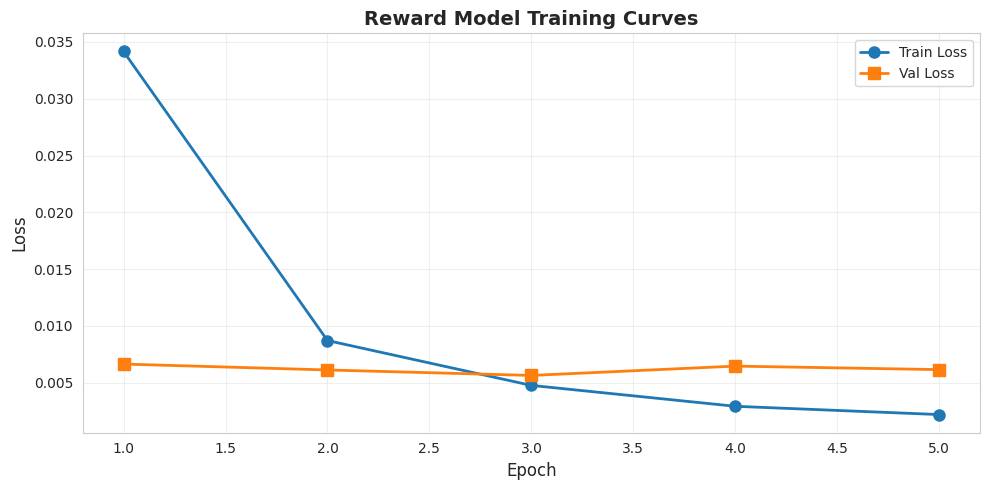

✅ Training curve saved to 'reward_model_training.png'


In [ ]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS_RM+1), train_losses, 'o-', label='Train Loss', linewidth=2, markersize=8)
plt.plot(range(1, EPOCHS_RM+1), val_losses, 's-', label='Val Loss', linewidth=2, markersize=8)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Reward Model Training Curves', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('reward_model_training.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training curve saved to 'reward_model_training.png'")


In [ ]:
# Load best reward model
reward_model.load_state_dict(torch.load('best_reward_model.pt'))
reward_model.eval()

print("✅ Loaded best reward model")
print("🔒 Reward model is now frozen and ready for PPO")


✅ Loaded best reward model
🔒 Reward model is now frozen and ready for PPO


## Part 2: PPO Fine-Tuning

### 2.1 Load OpenAssistant Dataset and Extract Prompts


In [ ]:
# Clear GPU memory before Part 2
torch.cuda.empty_cache()
gc.collect()

# Load OpenAssistant Dataset
print("📥 Loading OpenAssistant dataset...")
oasst = load_dataset("OpenAssistant/oasst1")

# Extract prompts
prompts = [ex['text'] for ex in oasst['train'] if ex['role'] == 'prompter']
ppo_prompts = random.sample(prompts, min(2000, len(prompts)))
print(f"✅ Sampled {len(ppo_prompts)} prompts for PPO")

# Tokenize prompts
MAX_PROMPT_LEN = 256
ppo_tokenized = [tokenizer.encode(p, truncation=True, max_length=MAX_PROMPT_LEN)
                 for p in ppo_prompts]
print(f"✅ Tokenized prompts")


📥 Loading OpenAssistant dataset...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-b42a775f407cee(…):   0%|          | 0.00/39.5M [00:00<?, ?B/s]

data/validation-00000-of-00001-134b8fd0c(…):   0%|          | 0.00/2.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/84437 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4401 [00:00<?, ? examples/s]

✅ Sampled 2000 prompts for PPO
✅ Tokenized prompts


### 2.2 PPO Configuration and Settings


In [ ]:
# Manual control variables (reduced for memory efficiency)
PPO_EPOCHS = 5
BATCH_SIZE = 4  # Reduced from 64 to avoid OOM
ACCUMULATION_STEPS = 8  # Simulate effective batch_size of 64

# Generation config
gen_kwargs = {
    'max_new_tokens': 32,  # Reduced from 128 for memory
    'do_sample': True,
    'top_k': 50,
    'top_p': 0.95,
    'temperature': 0.7,
    'pad_token_id': tokenizer.pad_token_id
}

print(f"✅ PPO Configuration:")
print(f"   Epochs: {PPO_EPOCHS}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Effective Batch Size: {BATCH_SIZE * ACCUMULATION_STEPS}")
print(f"   Max New Tokens: {gen_kwargs['max_new_tokens']}")


✅ PPO Configuration:
   Epochs: 5
   Batch Size: 4
   Effective Batch Size: 32
   Max New Tokens: 32


### 2.3 Part 2A: Full Fine-Tuning


In [ ]:
# ===== FULL FINE-TUNING =====
print("\n" + "="*80)
print("PPO TRAINING - FULL FINE-TUNING")
print("="*80)

# Load models
policy_full = AutoModelForCausalLMWithValueHead.from_pretrained(MODEL_NAME).to(device)
ref_full = AutoModelForCausalLMWithValueHead.from_pretrained(MODEL_NAME).to(device)
ref_full.eval()

# Optimizer
optimizer_full = torch.optim.AdamW(policy_full.parameters(), lr=1e-5)

kl_full, rewards_full = [], []
num_batches = len(ppo_tokenized) // BATCH_SIZE

print(f"Training for {PPO_EPOCHS} epochs with {num_batches} batches per epoch...")

for epoch in range(PPO_EPOCHS):
    print(f"\nEpoch {epoch+1}/{PPO_EPOCHS}")

    for batch_idx in tqdm(range(num_batches), desc=f"Epoch {epoch+1}"):
        start = batch_idx * BATCH_SIZE
        end = start + BATCH_SIZE
        batch_prompts = ppo_tokenized[start:end]

        query_tensors = [torch.tensor(p).to(device) for p in batch_prompts]

        # Generate responses
        policy_full.eval()
        response_tensors = []
        with torch.no_grad():
            for query in query_tensors:
                resp = policy_full.generate(query.unsqueeze(0), **gen_kwargs)
                response_tensors.append(resp[0])

        # Decode for reward model
        batch_resp_text = [tokenizer.decode(r, skip_special_tokens=True) for r in response_tensors]
        batch_prom_text = [tokenizer.decode(q, skip_special_tokens=True) for q in query_tensors]

        # Compute rewards
        reward_inputs = [f"Prompt: {p}\n\nResponse: {r}"
                         for p, r in zip(batch_prom_text, batch_resp_text)]

        reward_enc = tokenizer(reward_inputs, padding=True, truncation=True,
                                max_length=512, return_tensors='pt').to(device)

        with torch.no_grad():
            batch_rewards = reward_model(reward_enc['input_ids'], reward_enc['attention_mask'])

        rewards_full.extend([r.item() for r in batch_rewards])

        # Policy gradient update
        policy_full.train()

        # Prepare sequences
        full_sequences = [torch.cat([q, r[len(q):]]) for q, r in zip(query_tensors, response_tensors)]

        max_len = max(len(seq) for seq in full_sequences)
        padded_seqs = []
        attention_masks = []

        for seq in full_sequences:
            padding_length = max_len - len(seq)
            padded_seq = torch.cat([seq, torch.full((padding_length,), tokenizer.pad_token_id, device=device)])
            mask = torch.cat([torch.ones(len(seq), device=device), torch.zeros(padding_length, device=device)])
            padded_seqs.append(padded_seq)
            attention_masks.append(mask)

        input_ids = torch.stack(padded_seqs)
        attention_mask = torch.stack(attention_masks)

        # Forward pass
        outputs = policy_full(input_ids=input_ids, attention_mask=attention_mask)

        # FIXED: Extract logits from tuple
        if isinstance(outputs, tuple):
            logits = outputs[0]
        else:
            logits = outputs.logits

        # Compute loss
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = input_ids[..., 1:].contiguous()

        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        losses = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        losses = losses.view(shift_labels.size())

        reward_weights = torch.softmax(batch_rewards, dim=0).unsqueeze(1)
        weighted_loss = (losses * attention_mask[..., 1:] * reward_weights).sum() / attention_mask[..., 1:].sum()
        weighted_loss = weighted_loss / ACCUMULATION_STEPS

        # Backward
        weighted_loss.backward()

        if (batch_idx + 1) % ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(policy_full.parameters(), 1.0)
            optimizer_full.step()
            optimizer_full.zero_grad()

        # Compute KL divergence
        with torch.no_grad():
            ref_outputs = ref_full(input_ids=input_ids, attention_mask=attention_mask)

            # FIXED: Extract ref logits from tuple
            if isinstance(ref_outputs, tuple):
                ref_logits = ref_outputs[0]
            else:
                ref_logits = ref_outputs.logits

            kl_div = torch.nn.functional.kl_div(
                torch.nn.functional.log_softmax(shift_logits, dim=-1),
                torch.nn.functional.softmax(ref_logits[..., :-1, :], dim=-1),
                reduction='batchmean'
            )
            kl_full.append(kl_div.item())

        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()

print(f"\n✅ Full PPO Done!")
print(f"📊 Avg Reward: {np.mean(rewards_full):.4f}")
print(f"📊 Avg KL: {np.mean(kl_full):.4f}")

# Save model
policy_full.save_pretrained('ppo_full')
tokenizer.save_pretrained('ppo_full')
print("💾 Saved to ppo_full/")

# Clear memory
del policy_full, ref_full, optimizer_full
torch.cuda.empty_cache()
gc.collect()



PPO TRAINING - FULL FINE-TUNING


pytorch_model.bin:   0%|          | 0.00/548M [00:00<?, ?B/s]

Training for 5 epochs with 500 batches per epoch...

Epoch 1/5


Epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Epoch 2/5


Epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 3/5


Epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 4/5


Epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 5/5


Epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]


✅ Full PPO Done!
📊 Avg Reward: 0.0466
📊 Avg KL: 142.2816
💾 Saved to ppo_full/


7106

### 2.4 Part 2B: LoRA Fine-Tuning


In [ ]:
# ===== LoRA FINE-TUNING =====
print("\n" + "="*80)
print("PPO TRAINING - LoRA FINE-TUNING")
print("="*80)

# Load models
policy_lora = AutoModelForCausalLMWithValueHead.from_pretrained(MODEL_NAME)

# Configure LoRA
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["c_attn"],
    lora_dropout=0.2,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

policy_lora.pretrained_model = get_peft_model(policy_lora.pretrained_model, lora_config)
policy_lora = policy_lora.to(device)
policy_lora.pretrained_model.print_trainable_parameters()

ref_lora = AutoModelForCausalLMWithValueHead.from_pretrained(MODEL_NAME).to(device)
ref_lora.eval()

# Optimizer
optimizer_lora = torch.optim.AdamW(policy_lora.parameters(), lr=1e-5)

kl_lora, rewards_lora = [], []

print(f"Training for {PPO_EPOCHS} epochs with {num_batches} batches per epoch...")

for epoch in range(PPO_EPOCHS):
    print(f"\nEpoch {epoch+1}/{PPO_EPOCHS}")

    for batch_idx in tqdm(range(num_batches), desc=f"Epoch {epoch+1}"):
        start = batch_idx * BATCH_SIZE
        end = start + BATCH_SIZE
        batch_prompts = ppo_tokenized[start:end]

        query_tensors = [torch.tensor(p).to(device) for p in batch_prompts]

        # Generate responses
        policy_lora.eval()
        response_tensors = []
        with torch.no_grad():
            for query in query_tensors:
                resp = policy_lora.generate(query.unsqueeze(0), **gen_kwargs)
                response_tensors.append(resp[0])

        # Decode
        batch_resp_text = [tokenizer.decode(r, skip_special_tokens=True) for r in response_tensors]
        batch_prom_text = [tokenizer.decode(q, skip_special_tokens=True) for q in query_tensors]

        # Compute rewards
        reward_inputs = [f"Prompt: {p}\n\nResponse: {r}"
                         for p, r in zip(batch_prom_text, batch_resp_text)]

        reward_enc = tokenizer(reward_inputs, padding=True, truncation=True,
                                max_length=512, return_tensors='pt').to(device)

        with torch.no_grad():
            batch_rewards = reward_model(reward_enc['input_ids'], reward_enc['attention_mask'])

        rewards_lora.extend([r.item() for r in batch_rewards])

        # Policy update
        policy_lora.train()

        full_sequences = [torch.cat([q, r[len(q):]]) for q, r in zip(query_tensors, response_tensors)]

        max_len = max(len(seq) for seq in full_sequences)
        padded_seqs = []
        attention_masks = []

        for seq in full_sequences:
            padding_length = max_len - len(seq)
            padded_seq = torch.cat([seq, torch.full((padding_length,), tokenizer.pad_token_id, device=device)])
            mask = torch.cat([torch.ones(len(seq), device=device), torch.zeros(padding_length, device=device)])
            padded_seqs.append(padded_seq)
            attention_masks.append(mask)

        input_ids = torch.stack(padded_seqs)
        attention_mask = torch.stack(attention_masks)

        outputs = policy_lora(input_ids=input_ids, attention_mask=attention_mask)

        if isinstance(outputs, tuple):
            logits = outputs[0]
        else:
            logits = outputs.logits

        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = input_ids[..., 1:].contiguous()

        loss_fct = torch.nn.CrossEntropyLoss(reduction='none')
        losses = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        losses = losses.view(shift_labels.size())

        reward_weights = torch.softmax(batch_rewards, dim=0).unsqueeze(1)
        weighted_loss = (losses * attention_mask[..., 1:] * reward_weights).sum() / attention_mask[..., 1:].sum()
        weighted_loss = weighted_loss / ACCUMULATION_STEPS

        weighted_loss.backward()

        if (batch_idx + 1) % ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(policy_lora.parameters(), 1.0)
            optimizer_lora.step()
            optimizer_lora.zero_grad()

        with torch.no_grad():
            ref_outputs = ref_lora(input_ids=input_ids, attention_mask=attention_mask)

            if isinstance(ref_outputs, tuple):
                ref_logits = ref_outputs[0]
            else:
                ref_logits = ref_outputs.logits

            kl_div = torch.nn.functional.kl_div(
                torch.nn.functional.log_softmax(shift_logits, dim=-1),
                torch.nn.functional.softmax(ref_logits[..., :-1, :], dim=-1),
                reduction='batchmean'
            )
            kl_lora.append(kl_div.item())

        if batch_idx % 10 == 0:
            torch.cuda.empty_cache()

print(f"\n✅ LoRA PPO Done!")
print(f"📊 Avg Reward: {np.mean(rewards_lora):.4f}")
print(f"📊 Avg KL: {np.mean(kl_lora):.4f}")

# Save model
policy_lora.pretrained_model.save_pretrained('ppo_lora')
tokenizer.save_pretrained('ppo_lora')
print("💾 Saved to ppo_lora/")

# Clear memory
del policy_lora, ref_lora, optimizer_lora
torch.cuda.empty_cache()
gc.collect()



PPO TRAINING - LoRA FINE-TUNING
trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364
Training for 5 epochs with 500 batches per epoch...

Epoch 1/5


Epoch 1:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 2/5


Epoch 2:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 3/5


Epoch 3:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 4/5


Epoch 4:   0%|          | 0/500 [00:00<?, ?it/s]


Epoch 5/5


Epoch 5:   0%|          | 0/500 [00:00<?, ?it/s]


✅ LoRA PPO Done!
📊 Avg Reward: 0.0456
📊 Avg KL: 68.1550
💾 Saved to ppo_lora/


483

## Part 3: Evaluation & Reporting

### 3.1 Load Models for Evaluation


In [ ]:
# Clear memory
torch.cuda.empty_cache()
gc.collect()

# Select 50 unseen prompts
eval_prompts = random.sample([p for p in prompts if p not in ppo_prompts], 50)
print(f"✅ Selected {len(eval_prompts)} unseen evaluation prompts")

# Load models
print("Loading models for evaluation...")
pretrained = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(device).eval()
full_ft = AutoModelForCausalLMWithValueHead.from_pretrained('ppo_full').to(device).eval()

# Load LoRA model
base_for_lora = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
lora_ft = PeftModel.from_pretrained(base_for_lora, 'ppo_lora').to(device).eval()

print("✅ All models loaded")


✅ Selected 50 unseen evaluation prompts
Loading models for evaluation...


Some weights of the model checkpoint at ppo_full were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✅ All models loaded


### 3.2 Generate Responses and Compute Reward Scores


In [ ]:
# Generate responses
print("Generating responses for evaluation...")
responses_pre, responses_full, responses_lora = [], [], []

for prompt in tqdm(eval_prompts, desc="Generating"):
    inp = tokenizer.encode(prompt, return_tensors='pt', truncation=True, max_length=256).to(device)

    with torch.no_grad():
        # Pretrained
        out_pre = pretrained.generate(inp, **gen_kwargs)
        responses_pre.append(tokenizer.decode(out_pre[0][inp.shape[1]:], skip_special_tokens=True))

        # Full
        out_full = full_ft.generate(inp, **gen_kwargs)
        responses_full.append(tokenizer.decode(out_full[0][inp.shape[1]:], skip_special_tokens=True))

        # LoRA
        out_lora = lora_ft.generate(inp, **gen_kwargs)
        responses_lora.append(tokenizer.decode(out_lora[0][inp.shape[1]:], skip_special_tokens=True))

print("✅ Generated all responses")

# Score responses
def score_responses(prompts, responses):
    scores = []
    for p, r in zip(prompts, responses):
        inp = f"Prompt: {p}\n\nResponse: {r}"
        enc = tokenizer(inp, truncation=True, max_length=512, padding='max_length', return_tensors='pt').to(device)
        with torch.no_grad():
            score = reward_model(enc['input_ids'], enc['attention_mask']).item()
        scores.append(score)
    return scores

print("Computing reward scores...")
scores_pre = score_responses(eval_prompts, responses_pre)
scores_full = score_responses(eval_prompts, responses_full)
scores_lora = score_responses(eval_prompts, responses_lora)

# Metrics
avg_pre = np.mean(scores_pre)
avg_full = np.mean(scores_full)
avg_lora = np.mean(scores_lora)
gain_full = avg_full - avg_pre
gain_lora = avg_lora - avg_pre

print("\n" + "="*80)
print("REWARD SCORE EVALUATION")
print("="*80)
print(f"Pretrained:  {avg_pre:.4f}")
print(f"Full PPO:    {avg_full:.4f}  (gain: {gain_full:+.4f})")
print(f"LoRA PPO:    {avg_lora:.4f}  (gain: {gain_lora:+.4f})")
print("="*80)


Generating responses for evaluation...


Generating:   0%|          | 0/50 [00:00<?, ?it/s]

✅ Generated all responses
Computing reward scores...

REWARD SCORE EVALUATION
Pretrained:  0.0440
Full PPO:    0.0480  (gain: +0.0040)
LoRA PPO:    0.0396  (gain: -0.0044)


### 3.3 Plot Evaluation Results


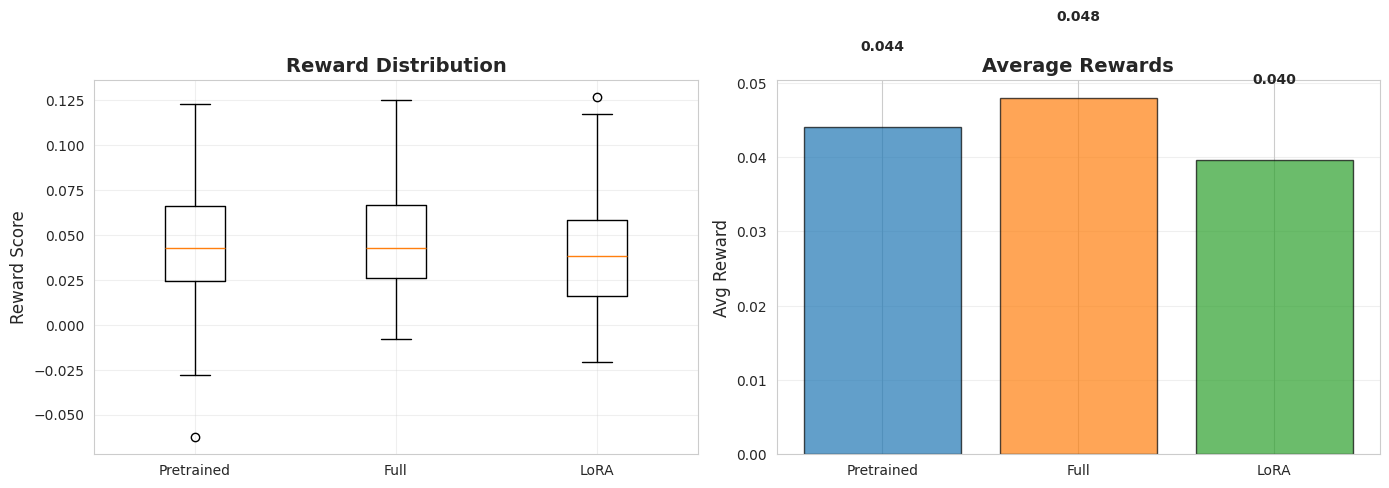

✅ Saved reward_evaluation.png


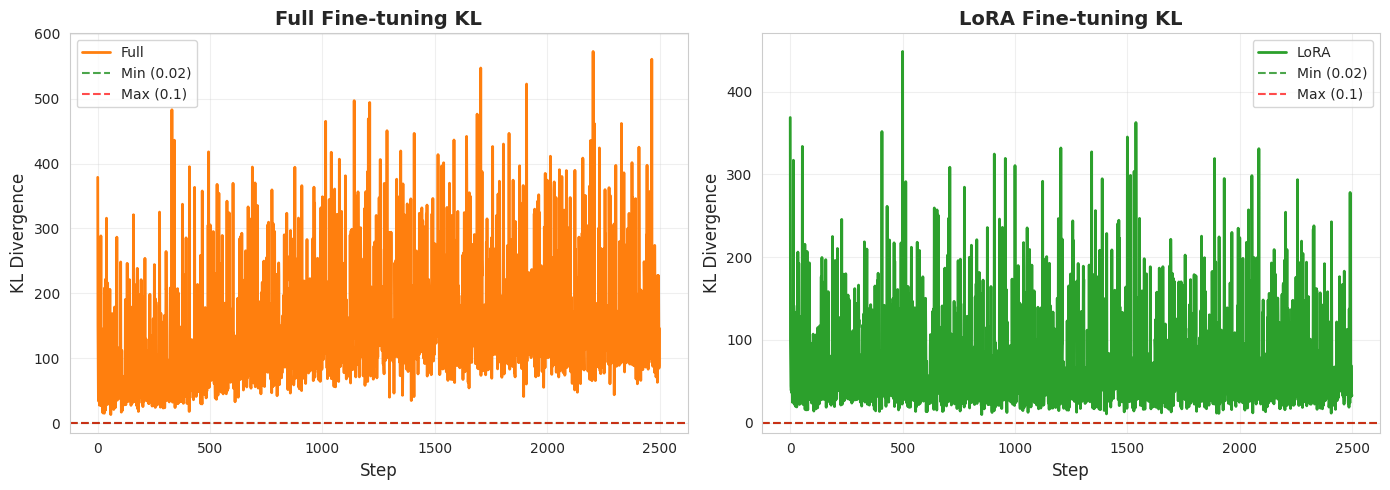

✅ Saved kl_divergence.png

KL Divergence Interpretation:
Full: Avg KL = 142.2816
LoRA: Avg KL = 68.1550


In [ ]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
ax[0].boxplot([scores_pre, scores_full, scores_lora], labels=['Pretrained', 'Full', 'LoRA'])
ax[0].set_ylabel('Reward Score', fontsize=12)
ax[0].set_title('Reward Distribution', fontsize=14, fontweight='bold')
ax[0].grid(True, alpha=0.3)

# Bar plot
ax[1].bar(['Pretrained', 'Full', 'LoRA'], [avg_pre, avg_full, avg_lora],
          color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7, edgecolor='black')
ax[1].set_ylabel('Avg Reward', fontsize=12)
ax[1].set_title('Average Rewards', fontsize=14, fontweight='bold')
ax[1].grid(True, alpha=0.3, axis='y')

for i, (model, reward) in enumerate(zip(['Pretrained', 'Full', 'LoRA'], [avg_pre, avg_full, avg_lora])):
    ax[1].text(i, reward + 0.01, f'{reward:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('reward_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved reward_evaluation.png")

# KL plots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(kl_full, label='Full', linewidth=2, color='#ff7f0e')
ax[0].axhline(0.02, color='g', linestyle='--', alpha=0.7, label='Min (0.02)')
ax[0].axhline(0.1, color='r', linestyle='--', alpha=0.7, label='Max (0.1)')
ax[0].set_xlabel('Step', fontsize=12)
ax[0].set_ylabel('KL Divergence', fontsize=12)
ax[0].set_title('Full Fine-tuning KL', fontsize=14, fontweight='bold')
ax[0].legend(fontsize=10)
ax[0].grid(True, alpha=0.3)

ax[1].plot(kl_lora, label='LoRA', linewidth=2, color='#2ca02c')
ax[1].axhline(0.02, color='g', linestyle='--', alpha=0.7, label='Min (0.02)')
ax[1].axhline(0.1, color='r', linestyle='--', alpha=0.7, label='Max (0.1)')
ax[1].set_xlabel('Step', fontsize=12)
ax[1].set_ylabel('KL Divergence', fontsize=12)
ax[1].set_title('LoRA Fine-tuning KL', fontsize=14, fontweight='bold')
ax[1].legend(fontsize=10)
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kl_divergence.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved kl_divergence.png")

# KL interpretation
print("\nKL Divergence Interpretation:")
print(f"Full: Avg KL = {np.mean(kl_full):.4f}")
print(f"LoRA: Avg KL = {np.mean(kl_lora):.4f}")


### 3.4 Manual Human Evaluation

Select 3 prompts and generate responses from all 3 models for manual rating (1-5 scale).


In [ ]:
# Select 3 prompts for manual evaluation
manual_prompts = random.sample(eval_prompts, 3)

print("="*80)
print("MANUAL EVALUATION PROMPTS")
print("="*80)

for i, prompt in enumerate(manual_prompts, 1):
    inp = tokenizer.encode(prompt, return_tensors='pt', truncation=True, max_length=256).to(device)

    print(f"\n{'='*80}")
    print(f"PROMPT {i}")
    print(f"{'='*80}")
    print(prompt)

    with torch.no_grad():
        # Pretrained
        out_pre = pretrained.generate(inp, **gen_kwargs)
        print(f"\n--- Pretrained ---")
        print(tokenizer.decode(out_pre[0][inp.shape[1]:], skip_special_tokens=True))

        # Full
        out_full = full_ft.generate(inp, **gen_kwargs)
        print(f"\n--- Full PPO ---")
        print(tokenizer.decode(out_full[0][inp.shape[1]:], skip_special_tokens=True))

        # LoRA
        out_lora = lora_ft.generate(inp, **gen_kwargs)
        print(f"\n--- LoRA PPO ---")
        print(tokenizer.decode(out_lora[0][inp.shape[1]:], skip_special_tokens=True))

print("\n" + "="*80)
print("⭐ MANUALLY RATE THESE IN YOUR REPORT (1-5 scale)")
print("   - Coherence, Relevance, Helpfulness, Completeness, Hallucination/Toxicity")
print("="*80)


MANUAL EVALUATION PROMPTS

PROMPT 1
Acabo de cumplir la edad suficiente para beber alcohol con mis amigos, ¿qué bebidas me recomiendas pedir en el bar para un novato como yo? Ellos suelen pedir bebidas fuertes como el tequila o vodka y no me gustaría empezar por esas.

--- Pretrained ---


Hendricks: ¿qué, la salva de las cuatro de estar o sua esta el bar?

R

--- Full PPO ---
 ¿Qué bebidas me recomiendas pedir en el bar para un novato como yo? Ellos suelen pedir

--- LoRA PPO ---


Etude blanc.

I want you to drink, as I do, but you won't, because you're afraid of the drink

PROMPT 2
Would you consider a happy meal or a combo at a Chinese restaurant a fast food prix fixe meal?

I noticed that you did not recommend Chinese or Vietnamese as cheap food options. Do you think your training data might be biased?

--- Pretrained ---


I think my training data might be biased because I am a student and not a regular person. I am not a student but I have a lot of

--- Full PPO ---
 Do you thin

## BONUS: DCGAN for Medical Image Synthesis (3 Points)

### BONUS 1: Load Medical Dataset

**⚠️ IMPORTANT:** Change `STUDENT_ID` to your actual ID!


In [10]:
# BONUS: DCGAN
STUDENT_ID = "017660669"
last_digit = int(str(STUDENT_ID)[-1])

if last_digit % 2 == 0:
    from medmnist import DermaMNIST
    gan_dataset = DermaMNIST(split="train", download=True)
    dataset_name = "DermaMNIST"
else:
    from medmnist import ChestMNIST
    gan_dataset = ChestMNIST(split="train", download=True)
    dataset_name = "ChestMNIST"

print(f"Using {dataset_name} (Student ID ends in {last_digit})")

# Prepare data
from torchvision import transforms
import numpy as np

# Get sample to determine dimensions - FIXED
sample_img, _ = gan_dataset[0]

# Convert PIL Image to numpy array to get shape
if hasattr(sample_img, 'shape'):
    # Already numpy array
    img_array = sample_img
else:
    # PIL Image - convert to numpy
    img_array = np.array(sample_img)

# Determine image properties
if len(img_array.shape) == 3:
    img_channels = img_array.shape[2] if img_array.shape[2] <= 3 else 1
else:
    img_channels = 1

img_size = img_array.shape[0]  # Height (assume square images)

print(f"Image size: {img_size}x{img_size}, Channels: {img_channels}")

# Transform - FIXED
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*img_channels, [0.5]*img_channels)
])

class MedDataset(Dataset):
    def __init__(self, med_dataset, transform=None):
        self.dataset = med_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]

        # Convert PIL Image to numpy if needed
        if not isinstance(img, np.ndarray):
            img = np.array(img)

        # Ensure correct shape for ToTensor
        if len(img.shape) == 2:
            img = img[:, :, np.newaxis]  # Add channel dimension

        # Convert to PIL Image for transforms
        from PIL import Image
        img = Image.fromarray(img.squeeze() if img.shape[2] == 1 else img)

        if self.transform:
            img = self.transform(img)

        return img

med_data = MedDataset(gan_dataset, transform)
gan_loader = DataLoader(med_data, batch_size=128, shuffle=True)
print(f"✅ Dataset ready: {len(med_data)} images")

100%|██████████| 82.8M/82.8M [00:13<00:00, 6.20MB/s]


Using ChestMNIST (Student ID ends in 9)
Image size: 28x28, Channels: 1
✅ Dataset ready: 78468 images


### BONUS 2: Define DCGAN Architecture


In [11]:
# DCGAN Models
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=3, img_size=28):
        super().__init__()
        self.img_size = img_size
        self.init_size = img_size // 4

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 512 * self.init_size * self.init_size),
            nn.BatchNorm1d(512 * self.init_size * self.init_size),
            nn.ReLU(True)
        )

        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.Conv2d(128, img_channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(x.size(0), 512, self.init_size, self.init_size)
        return self.conv_blocks(x)

class Discriminator(nn.Module):
    def __init__(self, img_channels=3, img_size=28):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(img_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 3, 2, 1, bias=False),
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 3, 1, 1, bias=False),
            nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(512, 1), nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)

# Initialize
latent_dim = 100
G = Generator(latent_dim, img_channels, img_size).to(device)
D = Discriminator(img_channels, img_size).to(device)
print(f"✅ Generator: {sum(p.numel() for p in G.parameters()):,} parameters")
print(f"✅ Discriminator: {sum(p.numel() for p in D.parameters()):,} parameters")


✅ Generator: 5,207,425 parameters
✅ Discriminator: 1,608,961 parameters


### BONUS 3: Train DCGAN


In [12]:
# Training
EPOCHS_GAN = 1000
lr, beta1, beta2 = 0.0002, 0.5, 0.999
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
criterion = nn.BCELoss()

print("="*80)
print(f"TRAINING DCGAN ON {dataset_name}")
print("="*80)

g_losses, d_losses = [], []
fixed_noise = torch.randn(32, latent_dim, device=device)

for epoch in range(EPOCHS_GAN):
    epoch_g_loss, epoch_d_loss = 0, 0

    for real_imgs in gan_loader:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # Train Generator
        opt_G.zero_grad()
        z = torch.randn(batch_size, latent_dim, device=device)
        gen_imgs = G(z)
        g_loss = criterion(D(gen_imgs), valid)
        g_loss.backward()
        opt_G.step()

        # Train Discriminator
        opt_D.zero_grad()
        real_loss = criterion(D(real_imgs), valid)
        fake_loss = criterion(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        opt_D.step()

        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()

    g_losses.append(epoch_g_loss / len(gan_loader))
    d_losses.append(epoch_d_loss / len(gan_loader))

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}: D={d_losses[-1]:.4f}, G={g_losses[-1]:.4f}")

print("✅ DCGAN Training Complete!")


TRAINING DCGAN ON ChestMNIST
Epoch 100: D=0.2889, G=1.9693
Epoch 200: D=0.2171, G=2.6002
Epoch 300: D=0.1552, G=3.0691
Epoch 400: D=0.1284, G=3.4770
Epoch 500: D=0.1242, G=3.7041
Epoch 600: D=0.0836, G=4.1535
Epoch 700: D=0.0982, G=4.0640
Epoch 800: D=0.0831, G=4.2761
Epoch 900: D=0.0720, G=4.6887
Epoch 1000: D=0.0653, G=4.9040
✅ DCGAN Training Complete!


### BONUS 4: Generate and Evaluate


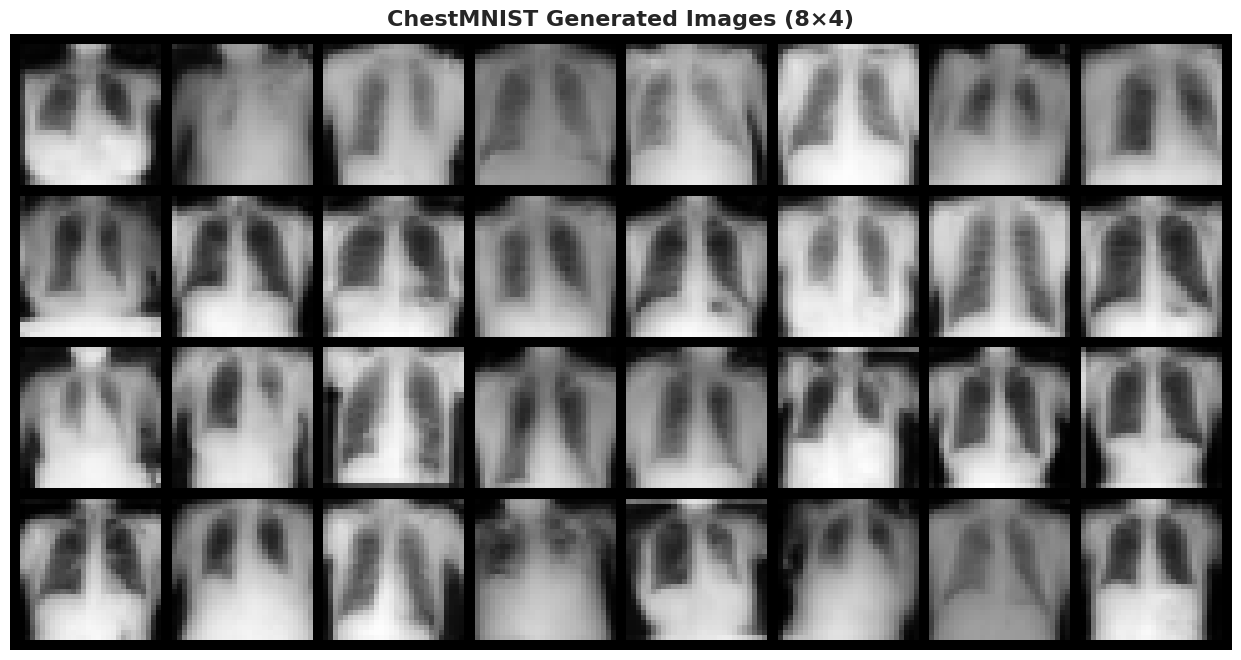

✅ Saved dcgan_samples.png

DCGAN EVALUATION
Final G Loss: 4.9040
Final D Loss: 0.0653

⭐ For your report, evaluate:
  1. Sample diversity (do images look different?)
  2. Mode collapse (many identical images?)
  3. Realism (do they look like medical images?)


In [13]:
# Generate samples
from torchvision.utils import make_grid

G.eval()
with torch.no_grad():
    samples = G(fixed_noise)
    grid = make_grid(samples.cpu(), nrow=8, normalize=True, padding=2)

    plt.figure(figsize=(16, 8))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.title(f'{dataset_name} Generated Images (8×4)', fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.savefig('dcgan_samples.png', dpi=300, bbox_inches='tight')
    plt.show()

print("✅ Saved dcgan_samples.png")

# Evaluation
print("\n" + "="*80)
print("DCGAN EVALUATION")
print("="*80)
print(f"Final G Loss: {g_losses[-1]:.4f}")
print(f"Final D Loss: {d_losses[-1]:.4f}")
print("\n⭐ For your report, evaluate:")
print("  1. Sample diversity (do images look different?)")
print("  2. Mode collapse (many identical images?)")
print("  3. Realism (do they look like medical images?)")
print("="*80)


## Assignment Complete! 🎉

### Generated Files:
- ✅ `reward_model_training.png`
- ✅ `reward_evaluation.png`
- ✅ `kl_divergence.png`
- ✅ `dcgan_samples.png`
- ✅ Model checkpoints saved

### For Your Report:
1. **Screenshots**: All 4 plots above
2. **Tables**: Preprocessed data (5 rows), Reward evaluation, 3 manual rating tables
3. **Discussions**: KL interpretation, comparative analysis, DCGAN evaluation

### Before Submission:
- [ ] Changed STUDENT_ID in BONUS section
- [ ] All cells executed successfully
- [ ] All manual evaluation tables filled (1-5 ratings)
- [ ] Report written with all sections
- [ ] Files named: `lastname_HW4.pdf`, `lastname_HW4_source_code.ipynb`

**Good luck! 🚀**
